# Custom bluesky plan

**Objective**: 
Build a custom plan for an up-down scan using `m2` and scaler1` channels `I0` and `diode`.  Make the counting time configurable.  Accept user metadata.

First, start the instrument package.

In [1]:
from instrument.collection import *

I Thu-22:36:46 - #### Bluesky Framework ####
I Thu-22:36:46 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Thu-22:36:46 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-22:36:46 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/initialize.py
I Thu-22:36:47 - using databroker catalog 'class_2021_03'
I Thu-22:36:47 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/metadata.py
I Thu-22:36:47 - #### Devices ####
I Thu-22:36:47 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/area_detector.py
I Thu-22:36:47 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/calculation_records.py
I Thu-22:36:50 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/ioc_stats.py
I Thu-22:36:50 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/motors.py
I Thu-22:36:50 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/noisy_detector.py
I Thu-22:36:50 - /home/mintadmin/Documen

## Select scaler channels
The scaler channels are selected by calling its `.select_channels()` method:

In [2]:
scaler1.select_channels(["I0", "diode"])

## Count time
The count time is in the `.preset_time` attribute.  The way to set the scaler with this time is to use ophyd's staging process.  Add `preset_time` to the `.stage_sigs` dictionary with the desired count time as the value.

In [3]:
scaler1.stage_sigs["preset_time"] = 1
scaler1.stage_sigs

OrderedDict([('preset_time', 1)])

# Construct the plan
Create a plan that scans up, then scans down (2 scans total).  Add `temperature` just to get some other interesting data.  We'll add a metadata key for the scan direction.

We'll do this in small steps starting with the innermost part.

In [4]:
def up_down_once(lo, hi, num, md={}):
    dets = [scaler1, temperature]
    _md = {}
    _md.update(md)
    _md["direction"] = "down"
    yield from bp.scan(dets, m2, lo, hi, num, md=_md)
    _md["direction"] = "down"
    yield from bp.scan(dets, m2, hi, lo, num, md=_md)

Verify that this code will process through the RunEngine by testing it without running it.  Use the `summarize_plan()` function imported from the `bluesky` package.  This will show the steps of the measurement.

In [5]:
summarize_plan(up_down_once(0, 1, 5))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================


Next, build a plan that runs this twice.

In [6]:
def up_down_twice(lo, hi, num, md={}):
    for i in range(2):
        yield from up_down_once(lo, hi, num, md=md)

In [7]:
summarize_plan(up_down_twice(0, 1, 5))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperatur

Finish the custom plan by setting the count time.  Give a default of 1.0 s.

In [8]:
def customScan(lo=0, hi=1, num=5, ct=1, md={}):
    scaler1.stage_sigs["preset_time"] = ct
    _md = {}
    _md.update(md)
    _md["count_time"] = ct
    _md["example"] = "customPlan"

    scaler1.select_channels(["I0", "diode"])
    yield from up_down_twice(lo, hi, num, md=_md)
    scaler1.select_channels()  # reset for all named channels
    del scaler1.stage_sigs["preset_time"]  # remove our custom staging

In [9]:
summarize_plan(customScan(md=dict(demo="concise custom plan example")))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperatur

## Run
Run the `customScan()` plan, using the RunEngine object: `RE()`



Transient Scan ID: 305     Time: 2021-03-11 22:36:52
Persistent Unique Scan ID: '4632fe1e-f3f3-4e75-a1cc-1bfe0ec794cc'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+----------------------+------------+------------+
|   seq_num |       time |         m2 | temperature_readback |         I0 |      diode |
+-----------+------------+------------+----------------------+------------+------------+
|         1 | 22:36:54.0 |    0.00000 |             24.92245 |          6 |          5 |
|         2 | 22:36:55.9 |    0.25000 |             24.77878 |          6 |          6 |
|         3 | 22:36:57.8 |    0.50000 |             24.74321 |          4 |          5 |
|         4 | 22:36:59.6 |    0.75000 |             25.09724 |          3 |          5 |
|         5 | 22:37:01.4 |    1.00000 |             25.31277 |          5 |          5 |
+-----------+------------+------------+----------------------+------------+------------+
generator scan ['4632fe1e'] (scan

('4632fe1e-f3f3-4e75-a1cc-1bfe0ec794cc',
 'c0c9a9dc-d99e-4a1e-96c9-41bca059b884',
 '479fd6e5-e564-43f9-b357-57ae0b65cbbc',
 '5fad5a25-eb34-4387-a798-d64fe4928691')

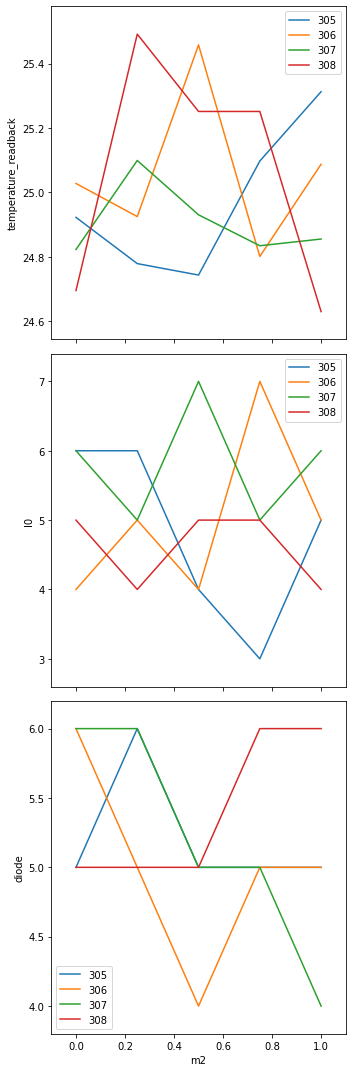

In [10]:
RE(customScan(md=dict(demo="concise custom plan example")))